In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import lr_scheduler
import re  # Import the regular expression module

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv") 
df = df.dropna().drop_duplicates()  # Clean missing and duplicate values
df['label'] = df['label'].astype(int)  # Ensure labels are integers

# Preprocessing function to clean text
def preprocess_text(text):
    # Lowercase the text (optional)
    text = text.lower()

    # Remove non-alphabetic characters (optional, depends on the use case)
    text = re.sub(r'[^a-zA-Z0-9\u0621-\u064A\s]', '', text)  # Retaining Arabic characters

    return text

# Apply preprocessing to all texts
df['content'] = df['content'].apply(preprocess_text)

# Extract texts and labels
texts = df['content'].values
labels = df['label'].values


# Split the dataset into training, validation, and test sets (70%, 15%, 15%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

print(df.head)

<bound method NDFrame.head of         label                                            content
0           1  النعال المريحة أرتدي هذه النعال كثيرافهي دافئة...
1           1  منتج جميل  خدمة سيئة لقد اشتريت زوجا من النعال...
2           1  جيد للأشياء الصغيرة هذا يعمل بشكل جيد لالتقاط ...
3           0  واهية للغاية flimsyif للغاية  فأنت تشتريه  كن ...
4           1  pop for girls and girly boys  والأشخاص الذين ي...
...       ...                                                ...
329995      0  doa فتح العلامة التجارية الجديدة من boxتم تثبي...
329996      0  شركة صعبة التعامل معها المنتج كان على ما يرامل...
329997      0  sdk sansa leather case فقير للغايةلم يتم الإعل...
329998      0  حسنا  لكن ليس رائعا حسنا  لقد اشتريت هذا السبب...
329999      1  مريحة جدا هذه النعال رائعةأنها ناعمة جدا ومريح...

[329968 rows x 2 columns]>


Class Distribution in Original Dataset:
label
1    166844
0    163124
Name: count, dtype: int64




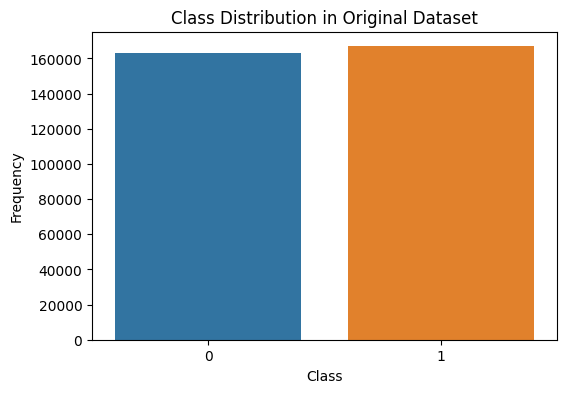

In [3]:
# Function to plot class distribution and print numbers
def plot_class_balance(labels, dataset_name="Dataset"):
    # Print the class distribution counts
    class_counts = labels.value_counts()
    print(f"Class Distribution in {dataset_name}:")
    print(class_counts)
    print("\n")

    # Plot class distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels)
    plt.title(f"Class Distribution in {dataset_name}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

# Plot class balance for the original dataset
plot_class_balance(df['label'], "Original Dataset")

In [4]:
# Load Arabic BERT model
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02").to(device)

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].to(device)  # CLS token embeddings



tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [5]:
# Convert train and test texts to embeddings
train_embeddings = torch.tensor(np.array([get_bert_embeddings([txt]).squeeze().cpu().numpy() for txt in train_texts])).to(device)
val_embeddings = torch.tensor(np.array([get_bert_embeddings([txt]).squeeze().cpu().numpy() for txt in val_texts])).to(device)
test_embeddings = torch.tensor(np.array([get_bert_embeddings([txt]).squeeze().cpu().numpy() for txt in test_texts])).to(device)



In [6]:
# Convert labels to tensor
train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1).to(device)



In [7]:

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_embeddings, train_labels)
val_data = TensorDataset(val_embeddings, val_labels)
test_data = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [8]:
# Define RNN-based models
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, output_size=1, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if out.dim() == 2:
            out = out.unsqueeze(1)  # Add a sequence length dimension if missing
        out = self.fc(out[:, -1, :])  # Take last time-step output
        return torch.sigmoid(out)  # Ensure output shape is [batch_size, 1]


class LSTMModel(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out,_ = self.lstm(x)
        if out.dim() == 2:
            out = out.unsqueeze(1)  # Add a sequence length dimension if missing
        out = self.fc(out[:, -1, :])  # Take last time-step output
        
        return torch.sigmoid(out)



class BiRNNModel(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, output_size=1, num_layers=1):
        super(BiRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for Bi-RNN

    def forward(self, x):
        # Forward pass through RNN layers
        rnn_out, hn = self.rnn(x)
    
        # If bi-directional, hn will have 2 directions, so we need to handle that
        if self.rnn.bidirectional:
            # Extract the forward and backward hidden states
            forward_h = hn[0]  # Hidden state from the last forward pass
            backward_h = hn[1]  # Hidden state from the last backward pass
    
            # Concatenate the forward and backward states
            out = torch.cat((forward_h, backward_h), dim=1)
        else:
            # For unidirectional RNN, just take the last hidden state
            out = hn[-1]  # Last hidden state in the sequence
    
        out = self.fc(out)  # Fully connected layer
        return torch.sigmoid(out)  # Sigmoid activation for binary classification

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, (hn, _) = self.lstm(x)
        if self.lstm.bidirectional:
            # Extract the forward and backward hidden states
            forward_h = hn[0]  # Hidden state from the last forward pass
            backward_h = hn[1]  # Hidden state from the last backward pass
            # Concatenate the forward and backward states
            out = torch.cat((forward_h, backward_h), dim=1)
        else:
            # For unidirectional RNN, just take the last hidden state
            out = hn[-1]  # Last hidden state in the sequence
        
        out = self.fc(out)  # Fully connected layer
        return torch.sigmoid(out)  # Sigmoid activation for binary classification


In [9]:
def train_model(model, train_loader, val_loader, test_loader, epochs=100, lr=0.001, patience=5, lr_decay_factor=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning Rate Scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=lr_decay_factor, verbose=True)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state_dict = None
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape the inputs to match (batch_size, sequence_length, input_size)
            batch_size = inputs.size(0)  # Get batch size
            sequence_length = 1  # Set sequence length to 1 (if your data is 1D, or adjust as needed)
            input_size = inputs.size(1)  # Assuming inputs are (batch_size, input_size)
            inputs = inputs.view(batch_size, sequence_length, input_size)  # Reshape to (batch_size, sequence_length, input_size)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Ensure labels are [batch_size, 1]

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
         # Evaluate on validation data after each epoch
        val_loss, val_accuracy = evaluate_model_val(model, val_loader, criterion)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            # Save the best model
            best_model_state_dict = model.state_dict()
            print("Saving model with best validation loss")
        else:
            early_stopping_counter += 1
        
        # Early stopping condition
        if early_stopping_counter >= patience:
            print(f"Early stopping after epoch {epoch+1}")
            break
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
    
     # After training, load the best model and evaluate
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
        print("Loaded best model for final evaluation.")
    
    # Final evaluation on the test set
    evaluate_model(model, test_loader)



In [10]:
def evaluate_model_val(model, test_loader,criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape the inputs to match (batch_size, sequence_length, input_size)
            batch_size = inputs.size(0)  # Get batch size
            sequence_length = 1  # Set sequence length to 1 (if your data is 1D, or adjust as needed)
            input_size = inputs.size(1)  # Assuming inputs are (batch_size, input_size)
            inputs = inputs.view(batch_size, sequence_length, input_size)  # Reshape to (batch_size, sequence_length, input_size)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Sigmoid output, so threshold at 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Calculate validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    accuracy = (correct / total)*100
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    return avg_val_loss, accuracy



In [11]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape the inputs to match (batch_size, sequence_length, input_size)
            batch_size = inputs.size(0)  # Get batch size
            sequence_length = 1  # Set sequence length to 1 (if your data is 1D, or adjust as needed)
            input_size = inputs.size(1)  # Assuming inputs are (batch_size, input_size)
            inputs = inputs.view(batch_size, sequence_length, input_size)  # Reshape to (batch_size, sequence_length, input_size)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Sigmoid output, so threshold at 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy=(correct / total)*100
    
    print(f"Test Accuracy: {accuracy:.4f}")


In [12]:
print("Training RNN Model...")
rnn_model = RNNModel()
train_model(rnn_model, train_loader, val_loader, test_loader)



Training RNN Model...
Epoch 1, Loss: 0.2941
Validation Loss: 0.2812
Validation Accuracy: 88.2675
Saving model with best validation loss
Epoch 2, Loss: 0.2812
Validation Loss: 0.2791
Validation Accuracy: 88.5059
Saving model with best validation loss
Epoch 3, Loss: 0.2772
Validation Loss: 0.2745
Validation Accuracy: 88.5544
Saving model with best validation loss
Epoch 4, Loss: 0.2745
Validation Loss: 0.2754
Validation Accuracy: 88.5403
Epoch 5, Loss: 0.2743
Validation Loss: 0.2797
Validation Accuracy: 88.6049
Epoch 6, Loss: 0.2728
Validation Loss: 0.2847
Validation Accuracy: 88.1281
Epoch 7, Loss: 0.2737
Validation Loss: 0.2927
Validation Accuracy: 87.4634
Epoch 8, Loss: 0.2644
Validation Loss: 0.2682
Validation Accuracy: 88.9322
Saving model with best validation loss
Epoch 9, Loss: 0.2602
Validation Loss: 0.2669
Validation Accuracy: 88.9161
Saving model with best validation loss
Epoch 10, Loss: 0.2585
Validation Loss: 0.2662
Validation Accuracy: 89.0272
Saving model with best validatio

In [13]:
print("Training LSTM Model...")
lstm_model = LSTMModel()
train_model(lstm_model, train_loader, val_loader, test_loader)



Training LSTM Model...
Epoch 1, Loss: 0.2898
Validation Loss: 0.2677
Validation Accuracy: 88.9666
Saving model with best validation loss
Epoch 2, Loss: 0.2694
Validation Loss: 0.2651
Validation Accuracy: 88.7787
Saving model with best validation loss
Epoch 3, Loss: 0.2637
Validation Loss: 0.2797
Validation Accuracy: 88.0372
Epoch 4, Loss: 0.2604
Validation Loss: 0.2632
Validation Accuracy: 89.1444
Saving model with best validation loss
Epoch 5, Loss: 0.2588
Validation Loss: 0.2618
Validation Accuracy: 89.0656
Saving model with best validation loss
Epoch 6, Loss: 0.2564
Validation Loss: 0.2594
Validation Accuracy: 89.2838
Saving model with best validation loss
Epoch 7, Loss: 0.2533
Validation Loss: 0.2617
Validation Accuracy: 89.1989
Epoch 8, Loss: 0.2518
Validation Loss: 0.2599
Validation Accuracy: 89.1464
Epoch 9, Loss: 0.2508
Validation Loss: 0.2592
Validation Accuracy: 89.2494
Saving model with best validation loss
Epoch 10, Loss: 0.2490
Validation Loss: 0.2611
Validation Accuracy: 

In [14]:
print("Training Bi-Directional RNN Model...")
bi_rnn_model = BiRNNModel()
train_model(bi_rnn_model, train_loader,  val_loader,test_loader)



Training Bi-Directional RNN Model...
Epoch 1, Loss: 0.2941
Validation Loss: 0.2792
Validation Accuracy: 88.4231
Saving model with best validation loss
Epoch 2, Loss: 0.2824
Validation Loss: 0.2949
Validation Accuracy: 87.6412
Epoch 3, Loss: 0.2802
Validation Loss: 0.2793
Validation Accuracy: 88.3928
Epoch 4, Loss: 0.2778
Validation Loss: 0.2749
Validation Accuracy: 88.7100
Saving model with best validation loss
Epoch 5, Loss: 0.2761
Validation Loss: 0.2841
Validation Accuracy: 87.8957
Epoch 6, Loss: 0.2774
Validation Loss: 0.2819
Validation Accuracy: 88.1907
Epoch 7, Loss: 0.2744
Validation Loss: 0.2798
Validation Accuracy: 88.6110
Epoch 8, Loss: 0.2741
Validation Loss: 0.2744
Validation Accuracy: 88.7140
Saving model with best validation loss
Epoch 9, Loss: 0.2734
Validation Loss: 0.2735
Validation Accuracy: 88.6211
Saving model with best validation loss
Epoch 10, Loss: 0.2714
Validation Loss: 0.2720
Validation Accuracy: 88.7201
Saving model with best validation loss
Epoch 11, Loss: 0

In [15]:
print("Training Bi-Directional LSTM Model...")
bi_lstm_model = BiLSTMModel()
train_model(bi_lstm_model, train_loader, val_loader, test_loader)

Training Bi-Directional LSTM Model...
Epoch 1, Loss: 0.2883
Validation Loss: 0.2685
Validation Accuracy: 88.9039
Saving model with best validation loss
Epoch 2, Loss: 0.2694
Validation Loss: 0.2653
Validation Accuracy: 89.1605
Saving model with best validation loss
Epoch 3, Loss: 0.2630
Validation Loss: 0.2757
Validation Accuracy: 88.3524
Epoch 4, Loss: 0.2599
Validation Loss: 0.2616
Validation Accuracy: 88.9989
Saving model with best validation loss
Epoch 5, Loss: 0.2566
Validation Loss: 0.2641
Validation Accuracy: 88.9706
Epoch 6, Loss: 0.2555
Validation Loss: 0.2675
Validation Accuracy: 89.0151
Epoch 7, Loss: 0.2533
Validation Loss: 0.2683
Validation Accuracy: 88.8453
Epoch 8, Loss: 0.2512
Validation Loss: 0.2600
Validation Accuracy: 89.3484
Saving model with best validation loss
Epoch 9, Loss: 0.2501
Validation Loss: 0.2691
Validation Accuracy: 89.0393
Epoch 10, Loss: 0.2481
Validation Loss: 0.2626
Validation Accuracy: 89.2656
Epoch 11, Loss: 0.2473
Validation Loss: 0.2628
Validati